# Introduction #
This kernel is writtern for the [Expedia Hotel Recommendations](https://www.kaggle.com/c/expedia-hotel-recommendations) competetion. If you Like the notebook and think that it helped you, <font color="red"><b> please upvote</b></font>.

---
## Table of Content
1. Data Preprocessing
2. Modeling and Evaluation
3. Final Prediction & Submission

In [1]:
# pandas
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

# get expedia & test csv files as a DataFrame
train_df = pd.read_csv('../input/train.csv', nrows=10000)
test_df    = pd.read_csv('../input/test.csv', nrows=10000)
destination = pd.read_csv('../input/destinations.csv', nrows=100000)

train_df.info()
print("----------------------------")
test_df.info()

# preview the data
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
date_time                    10000 non-null object
site_name                    10000 non-null int64
posa_continent               10000 non-null int64
user_location_country        10000 non-null int64
user_location_region         10000 non-null int64
user_location_city           10000 non-null int64
orig_destination_distance    6271 non-null float64
user_id                      10000 non-null int64
is_mobile                    10000 non-null int64
is_package                   10000 non-null int64
channel                      10000 non-null int64
srch_ci                      9993 non-null object
srch_co                      9993 non-null object
srch_adults_cnt              10000 non-null int64
srch_children_cnt            10000 non-null int64
srch_rm_cnt                  10000 non-null int64
srch_destination_id          10000 non-null int64
srch_destination_type_id     10000 non-n

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


# Data Preprocessing
The first step is to clean and pre-process the data and perform exploratory analysis to get some interesting insights into the process of choosing a hotel.

* Remove the users who did not booked the hotel
* Identify the searches by each user belonging to a specific type of destination
* orig_destination_distance contains Nan values
* The check-in and check-out dates to find the duration of the stay for each of the entries in the training set.


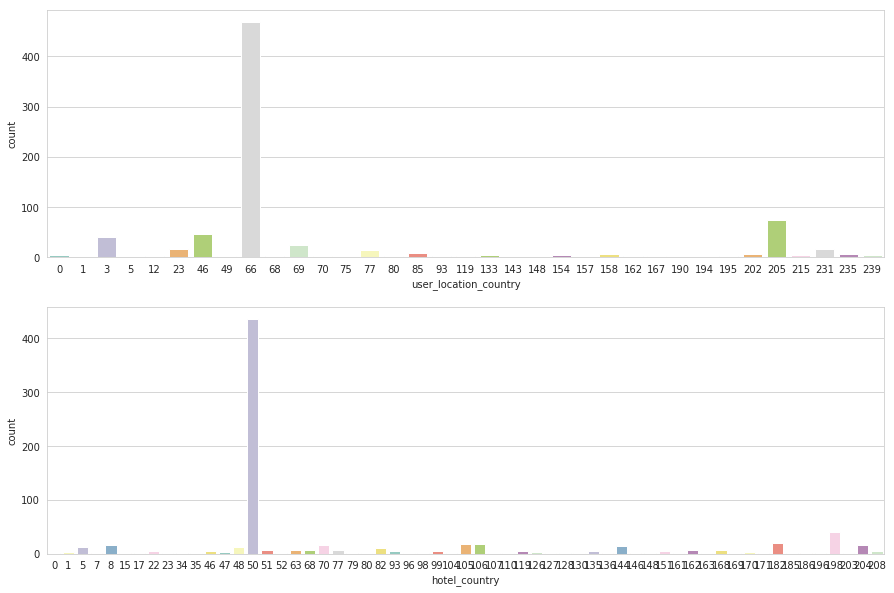

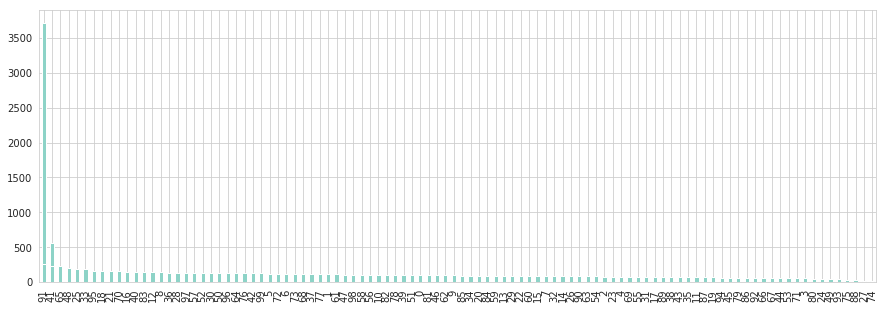

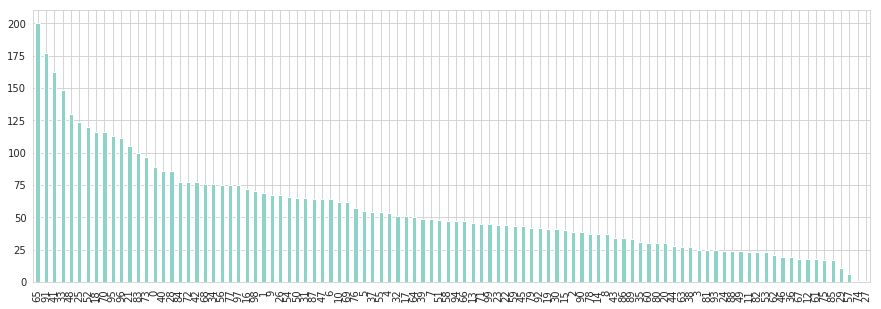

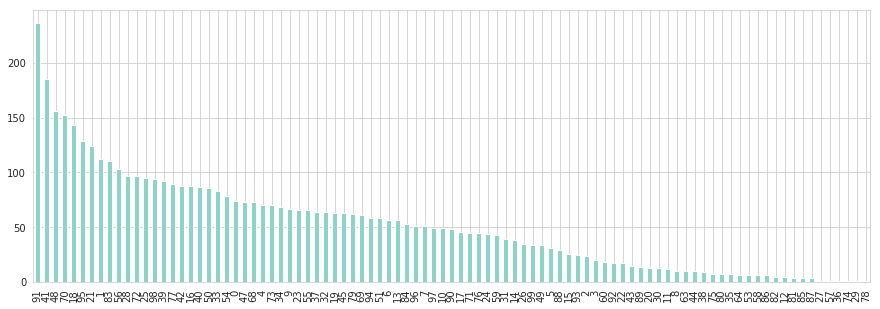

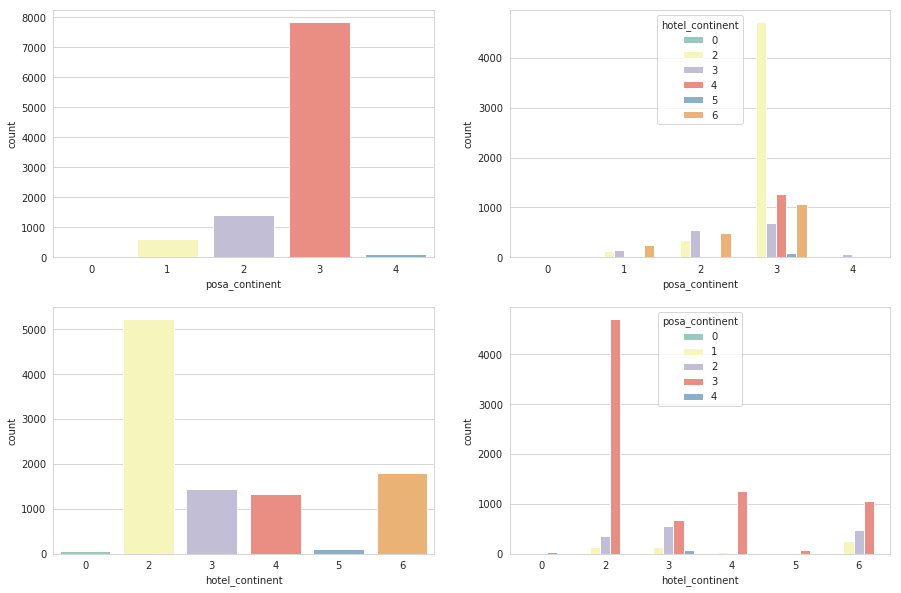

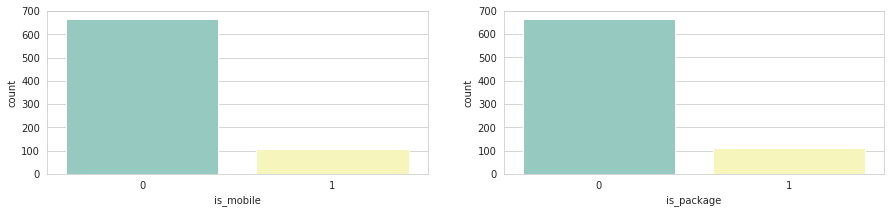

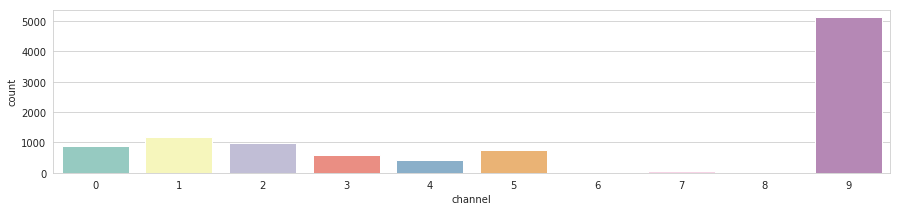

In [2]:
# Plot 
bookings_df = train_df[train_df["is_booking"] == 1]
fig, (axis1,axis2) = plt.subplots(2,1,figsize=(15,10))
# What are the most countries the customer travel from?
sns.countplot('user_location_country',data=bookings_df.sort_values(by=['user_location_country']),ax=axis1,palette="Set3")

# What are the most countries the customer travel to?
sns.countplot('hotel_country',data=bookings_df.sort_values(by=['hotel_country']),ax=axis2,palette="Set3")

# Combine both plots
# fig, (axis1) = plt.subplots(1,1,figsize=(15,5))
# sns.distplot(bookings_df["hotel_country"], kde=False, rug=False, bins=25, ax=axis1)
# sns.distplot(bookings_df["user_location_country"], kde=False, rug=False, bins=25, ax=axis1)

# Where do most of the customers from a country travel?
user_country_id = 66
fig, (axis1) = plt.subplots(1,1,figsize=(15,10))
country_customers = train_df[train_df["user_location_country"] == user_country_id]
country_customers["hotel_country"].value_counts().plot(kind='bar',colormap="Set3",figsize=(15,5))

# Plot frequency for each hotel_clusters
train_df["hotel_cluster"].value_counts().plot(kind='bar',colormap="Set3",figsize=(15,5))

# What are the most frequent hotel clusters booked by customers from a country?
fig, (axis1) = plt.subplots(1,1,figsize=(15,10))
customer_clusters = train_df[train_df["user_location_country"] == user_country_id]["hotel_cluster"]
customer_clusters.value_counts().plot(kind='bar',colormap="Set3",figsize=(15,5))

# What are the most frequent hotel clusters in a country?
country_id = 50
fig, (axis1) = plt.subplots(1,1,figsize=(15,10))
country_clusters = train_df[train_df["hotel_country"] == country_id]["hotel_cluster"]
country_clusters.value_counts().plot(kind='bar',colormap="Set3",figsize=(15,5))

# Plot post_continent & hotel_continent
fig, ((axis1,axis2),(axis3,axis4)) = plt.subplots(2,2,figsize=(15,10))

# Plot frequency for each posa_continent
sns.countplot('posa_continent', data=train_df,order=[0,1,2,3,4],palette="Set3",ax=axis1)

# Plot frequency for each posa_continent decomposed by hotel_continent
sns.countplot('posa_continent', hue='hotel_continent',data=train_df,order=[0,1,2,3,4],palette="Set3",ax=axis2)

# Plot frequency for each hotel_continent
sns.countplot('hotel_continent', data=train_df,order=[0,2,3,4,5,6],palette="Set3",ax=axis3)

# Plot frequency for each hotel_continent decomposed by posa_continent
sns.countplot('hotel_continent', hue='posa_continent', data=train_df, order=[0,2,3,4,5,6],palette="Set3",ax=axis4)

# Plot frequency of is_mobile & is_package
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,3))

# What's the frequency of bookings through mobile?
sns.countplot(x='is_mobile',data=bookings_df, order=[0,1], palette="Set3", ax=axis1)

# What's the frequency of bookings with package?
sns.countplot(x='is_package',data=bookings_df, order=[0,1], palette="Set3", ax=axis2)

# What's the most impactful channel?
fig, (axis1) = plt.subplots(1,1,figsize=(15,3))
sns.countplot(x='channel', order=list(range(0,10)), data=train_df, palette="Set3")

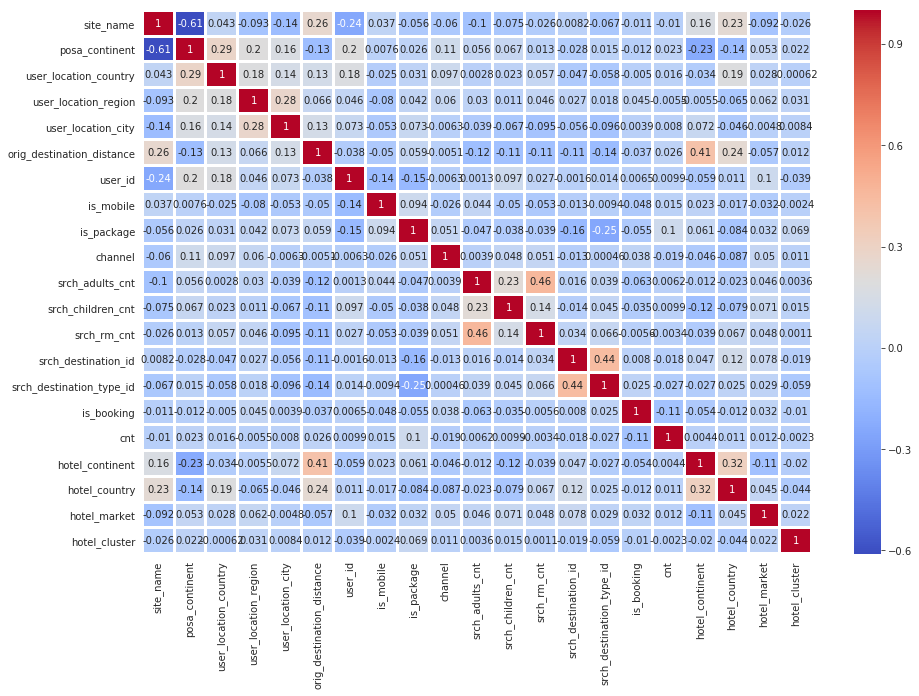

In [3]:
# heatmap
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.heatmap(train_df.corr(),cmap='coolwarm',ax=ax,annot=True,linewidths=2)


## Feature Engineering
**Additional features from date columns**
* stay_dur: number of duration of stay
* no_of_days_bet_booking: number of days between the booking and
* Cin_day: Check-in day
* Cin_month: Check-in month
* Cin_year: Check-out year

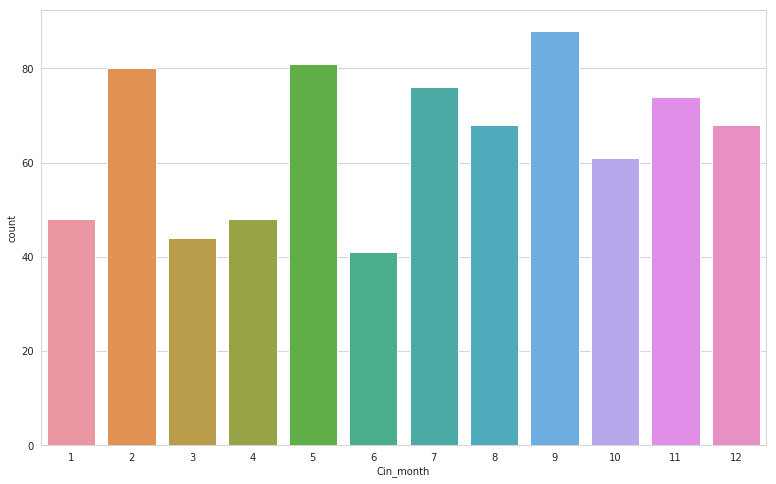

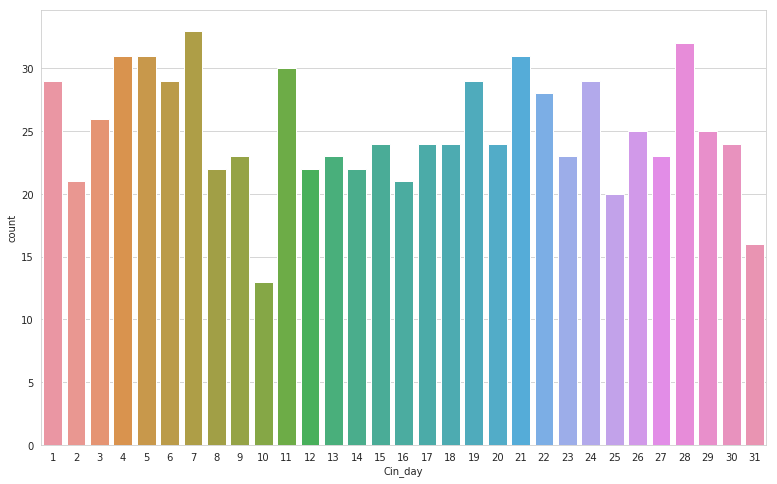

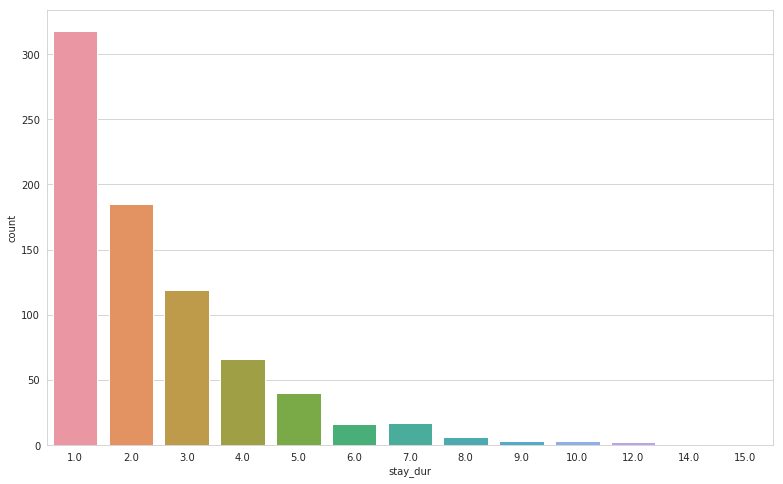

In [4]:

# Function to convert date object into relevant attributes
def convert_date_into_days(df):
    df['srch_ci'] = pd.to_datetime(df['srch_ci'])
    df['srch_co'] = pd.to_datetime(df['srch_co'])
    df['date_time'] = pd.to_datetime(df['date_time'])
    
    df['stay_dur'] = (df['srch_co'] - df['srch_ci']).astype('timedelta64[D]')
    df['no_of_days_bet_booking'] = (df['srch_ci'] - df['date_time']).astype('timedelta64[D]')
    
    # For hotel check-in
    # Month, Year, Day
    df['Cin_day'] = df["srch_ci"].apply(lambda x: x.day)
    df['Cin_month'] = df["srch_ci"].apply(lambda x: x.month)
    df['Cin_year'] = df["srch_ci"].apply(lambda x: x.year)
    
convert_date_into_days(train_df)
convert_date_into_days(test_df)

# Count the bookings in each month
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot('Cin_month',data=train_df[train_df["is_booking"] == 1],order=list(range(1,13)),ax=ax)

# Count the bookings as per the day
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot('Cin_day',data=train_df[train_df["is_booking"] == 1],order=list(range(1,32)),ax=ax)

# Count the bookings as per the stay_duration
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot('stay_dur',data=train_df[train_df["is_booking"] == 1],ax=ax)

# drop unnecessary columns, these columns won't be useful in analysis and prediction
test_user_id = test_df['user_id']
columns = ['date_time', 'srch_ci','user_id','srch_destination_type_id','srch_destination_id', 'site_name', 'user_location_region', 'user_location_city', 
                              'user_id', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt']
train_df.drop(columns=columns,axis=1,inplace=True)
test_df.drop(columns=columns,axis=1,inplace=True)

In [5]:
# Check the percentage of Nan in dataset
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df['hotel_cluster'].count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

# Fill nan with the day which has max occurence
train_df['Cin_day'] = train_df['Cin_day'].fillna(26.0)
train_df['Cin_month'] = train_df['Cin_month'].fillna(8.0)
train_df['Cin_year'] = train_df['Cin_year'].fillna(2014.0)
train_df['stay_dur'] = train_df['stay_dur'].fillna(1.0)
train_df['no_of_days_bet_booking'] = train_df['no_of_days_bet_booking'].fillna(0.0)

# Fill average values in place for nan, fill with mean
train_df['orig_destination_distance'].fillna(train_df['orig_destination_distance'].mean(), inplace=True)

# Prediction & Submission

## A simple solution
A very simple solution implemented with pandas to use the "most popular local hotel" as recommendation.

**Step 1**

Read in the train data using only the necessary columns. Specifying dtypes helps reduce memory requirements.
The file is read in chunks of 1 million rows each. In each chunk we count the number of rows and number of bookings for every destination-hotel cluster combination.

**Step 2**

Next we aggregate again to compute the total number of bookings over all chunks.
Compute the number of clicks by subtracting the number of bookings from total row counts.
Compute the 'relevance' of a hotel cluster with a weighted sum of bookings and clicks.

**Step 3**
Read in the test data and merge most popular hotel clusters.

In [6]:
# Step 1
train = pd.read_csv('../input/train.csv',
                    dtype={'is_booking':bool,'srch_destination_id':np.int32, 'hotel_cluster':np.int32},
                    usecols=['srch_destination_id','is_booking','hotel_cluster'],
                    chunksize=1000000)
aggs = []
print('-'*38)
for chunk in train:
    agg = chunk.groupby(['srch_destination_id',
                         'hotel_cluster'])['is_booking'].agg(['sum','count'])
    agg.reset_index(inplace=True)
    aggs.append(agg)
    print('.',end='')
print('')
aggs = pd.concat(aggs, axis=0)
aggs.head()

# Step 2
CLICK_WEIGHT = 0.05
agg = aggs.groupby(['srch_destination_id','hotel_cluster']).sum().reset_index()
agg['count'] -= agg['sum']
agg = agg.rename(columns={'sum':'bookings','count':'clicks'})
agg['relevance'] = agg['bookings'] + CLICK_WEIGHT * agg['clicks']
agg.head()

# Define a function to get most popular hotels for a destination group.
def most_popular(group, n_max=5):
    relevance = group['relevance'].values
    hotel_cluster = group['hotel_cluster'].values
    most_popular = hotel_cluster[np.argsort(relevance)[::-1]][:n_max]
    return np.array_str(most_popular)[1:-1] # remove square brackets

# Get most popular hotel clusters for all destinations.
most_pop = agg.groupby(['srch_destination_id']).apply(most_popular)
most_pop = pd.DataFrame(most_pop).rename(columns={0:'hotel_cluster'})
most_pop.head()

# Step 3: Read in the test data and merge most popular hotel clusters.
test = pd.read_csv('../input/test.csv',
                    dtype={'srch_destination_id':np.int32},
                    usecols=['srch_destination_id'],)
test = test.merge(most_pop, how='left',left_on='srch_destination_id',right_index=True)
test.head()

# Check hotel_cluster column in test for null values
test.hotel_cluster.isnull().sum()

# Let's fill nas with hotel clusters that are most popular overall.
most_pop_all = agg.groupby('hotel_cluster')['relevance'].sum().nlargest(5).index
most_pop_all = np.array_str(most_pop_all)[1:-1]
print(most_pop_all)

test.hotel_cluster.fillna(most_pop_all,inplace=True)

test.hotel_cluster.to_csv('submission.csv',header=True, index_label='id')

--------------------------------------
......................................
91 48 42 59 28
